In [1]:
%load_ext autoreload
%autoreload 2
from final_deliverable.utils_final import *

/Users/a14542/Desktop/UChicago/24 AU/Flexible Plan Investments/fpi_project_lab_autumn2024/analysis/utils.py:539: SyntaxWarning: invalid escape sequence '\d'
  combined_df.columns = [re.sub(f'_Asset \d+', '', col) if not col.startswith('Asset_') else col


In [2]:
rets_data_path = os.path.dirname(os.getcwd()) + '/data'
pred_data_path = os.path.dirname(os.getcwd()) + '/backtest'
analysis_data_path = os.path.dirname(os.getcwd()) + '/analysis'
weekly_rets_file = rets_data_path + '/broad_assets_weekly_rets.xlsx'
global_rets_file = rets_data_path + '/equity_global_monthly_rets.xlsx'
domestic_rets_file = rets_data_path + '/equity_domestic_monthly_rets.xlsx'
broad_assets_pred_file = analysis_data_path + '/broad_asset XGBoost-PCA Asset Mean Threshold Predictions.xlsx'
global_pred_file = pred_data_path + '/equity_global_predictions.xlsx'
domestic_pred_file = analysis_data_path + '/equity_domestic XGBoost-LDA Basic Threshold Predictions.xlsx'
broad_assets_weights_file = rets_data_path + '/classification_broad_assets_Drawdown_weight.xlsx'
global_weights_file = rets_data_path + '/classification_equity_global_Drawdown_weight.xlsx'
domestic_weights_file = rets_data_path + '/classification_equity_domestic_Sharpe_weight.xlsx'

## Before Everything

This notebook is for the implementation of the **defensive overlay** to mitigate portfolio drawdowns. This risk management strategy dynamically allocates portfolio weights to cash positions when pre-defined risk or drawdown thresholds are exceeded. By incorporating rolling variance and predicted return signals, this overlay ensures a robust response to market volatility and downside risks.

## Weekly / Monthly Returns Data Import

In [3]:
data = pd.read_excel(weekly_rets_file, index_col = 0)
global_data = pd.read_excel(global_rets_file, index_col = 0)
domestic_data = pd.read_excel(domestic_rets_file, index_col = 0)
display(data.head(), global_data.head(), domestic_data.head())

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318
2000-08-07,0.0679,0.0526,0.0159,0.0134,0.0365,-0.0237,-0.0196,-0.0116,0.0241,-0.0266,0.0346
2000-08-14,0.0157,0.0023,0.0152,0.0063,0.0171,0.0254,0.0294,0.0369,0.0085,0.0063,0.0481
2000-08-21,0.0095,0.0566,-0.0018,-0.0003,0.0068,-0.0264,0.0016,-0.0024,0.0077,0.0018,0.0384
2000-08-28,0.0184,0.0653,0.0019,0.0041,0.0379,-0.0353,0.0195,-0.0170,0.0019,-0.0095,0.0313


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2003-04-14,0.0059,0.0035,0.0000,0.0069,0.0000,0.0000,0.0090,0.0042,0.0000,0.0000,...,0.0000,0.0000,0.0000,-0.0028,-0.0009,-0.0028,0.0000,0.0000,0.0207,0.0204
2003-05-01,0.1023,0.1299,0.0000,0.0811,0.0000,0.0000,0.0997,0.0606,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0328,0.0056,0.0169,0.0000,0.0000,0.0332,0.0638
2003-06-02,0.0422,0.3734,0.0000,0.1223,0.0000,0.0000,0.1478,0.2189,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0603,0.0047,0.0370,0.0000,0.0000,0.0593,0.0683
2003-07-01,0.1001,0.1734,0.0000,0.0544,0.0000,0.0000,0.0618,0.1381,0.0000,0.0000,...,0.0000,0.0000,0.0000,-0.0115,0.0035,-0.0025,0.0000,0.0000,0.0158,0.0260
2003-08-01,0.0754,0.1196,0.0000,-0.0382,0.0000,0.0000,0.0560,0.0665,0.0000,0.0000,...,0.0000,0.0000,0.0000,-0.0922,-0.0049,-0.0515,0.0000,0.0000,-0.0002,0.0366


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-03,0.0000,0.0000,0.0000,-0.0338,0.0000,0.0000,0.0000,-0.0137,0.0000,0.0000,...,0.0115,0.0419,0.0675,0.1113,0.0419,0.0177,-0.0411,-0.0118,-0.0171,-0.0013
2001-02-01,0.0000,0.0000,0.0000,-0.0378,0.0000,0.0000,0.0000,0.0048,0.0000,0.0000,...,0.0166,0.0215,-0.0046,0.0319,0.0253,-0.0520,-0.0496,0.0120,0.0114,0.0100
2001-03-01,0.0000,0.0000,0.0000,0.0269,0.0000,0.0000,0.0000,0.0441,0.0000,0.0000,...,-0.0172,0.0704,0.0395,-0.1746,0.0087,0.0011,0.0999,0.0110,0.0135,0.0058
2001-04-02,0.0000,0.0000,0.0000,-0.0210,0.0000,0.0000,0.0000,0.0367,0.0000,0.0000,...,-0.0038,-0.0238,-0.0028,-0.1542,-0.0019,-0.0201,0.0181,0.0008,-0.0176,0.0081
2001-05-01,0.0000,0.0000,0.0000,0.0414,0.0000,0.0000,0.0000,0.0314,0.0000,0.0000,...,0.0053,0.1430,0.0607,0.2815,0.0649,0.0244,0.0337,-0.0122,-0.0239,0.0032


## Broad Assets / Equity Global & Domestic Classification Prediction Results Import

In [4]:
broad_assets_pred = pd.read_excel(broad_assets_pred_file)
global_pred = pd.read_excel(global_pred_file)
domestic_pred = pd.read_excel(domestic_pred_file)
display(broad_assets_pred.head(), global_pred.head(), domestic_pred.head())

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2004-10-11,1,1,1,0,1,0,1,0,0,0,0
1,2004-10-18,0,1,0,1,1,1,1,1,0,0,1
2,2004-10-25,1,0,0,0,0,0,0,0,1,1,1
3,2004-11-01,1,0,1,1,0,0,0,0,1,0,0
4,2004-11-08,0,0,0,0,0,1,1,0,1,0,0


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
0,2007-05-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
1,2007-06-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
2,2007-07-02,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
3,2007-08-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
4,2007-09-04,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
0,2004-06-01,NaN,NaN,NaN,0,0,0,0,1,0,...,0,0,0,0,1,1,0,1,1,1
1,2004-07-01,NaN,NaN,NaN,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,2004-08-02,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
3,2004-09-01,NaN,NaN,NaN,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,1,0
4,2004-10-01,NaN,NaN,NaN,1,0,0,0,1,0,...,1,1,1,1,1,1,1,0,0,0


## Broad Assets / Equity Global & Domestic MVO Weights Import

In [5]:
broad_assets_portfolio_weights = pd.read_excel(broad_assets_weights_file, index_col = 0)
equity_domestic_portfolio_weights = pd.read_excel(domestic_weights_file, index_col = 0)
equity_global_portfolio_weights = pd.read_excel(global_weights_file, index_col = 0)
display(broad_assets_portfolio_weights.head(), equity_domestic_portfolio_weights.head(), equity_global_portfolio_weights.head())

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2005-10-17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2288,0.4284,0.0782,0.0000,0.2645
2005-10-24,0.0116,0.0000,0.0964,0.1309,0.0000,0.0000,0.0000,0.5597,0.0000,0.0000,0.2014
2005-10-31,0.0000,0.3452,0.0000,0.4379,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2169
2005-11-07,0.0000,0.0000,0.0000,0.1729,0.0000,0.0000,0.2208,0.6063,0.0000,0.0000,0.0000
2005-11-14,0.0000,0.3346,0.0000,0.0000,0.0794,0.0000,0.0000,0.0000,0.5860,0.0000,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1414,0.0000,0.0000,0.1457,0.1389,0.1481,0.0000,0.1392,0.1448,0.0000
2005-07-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2575,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2406
2005-08-01,0.0000,0.0000,0.0000,0.1391,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.1337,0.1469,0.0000,0.0000,0.0000,0.0000
2005-09-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.2507,0.0000,0.2475,0.0000,0.0000,0.0000,0.0000
2005-10-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.2035,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-01,0.0000,0.0812,0.0000,0.0000,0.0000,0.0000,0.0000,0.7087,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2008-06-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6594,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1138
2008-07-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7355,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2008-08-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0173,0.0000,0.0000,0.0000,0.0000,0.0000
2008-09-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.6728,0.0000,0.3272,0.0000,0.0000,0.0000,0.0000


***
## General Preparation for All Assets Before Defensive Overlay

Generate the maximum drawdown, rolling volatility and rolling VaR of the broad assets, equity global and domestic predicted data

In [6]:
broad_assets_date_shifted = broad_assets_pred['Date'].shift(-1)
broad_assets_pred_shifted = broad_assets_pred.copy()
broad_assets_pred_shifted['Date'] = broad_assets_date_shifted

equity_domestic_date_shifted = domestic_pred['Date'].shift(-1)
equity_domestic_pred_shifted = domestic_pred.copy()
equity_domestic_pred_shifted['Date'] = equity_domestic_date_shifted

equity_global_date_shifted = global_pred['Date'].shift(-1)
equity_global_pred_shifted = global_pred.copy()
equity_global_pred_shifted['Date'] = equity_global_date_shifted
display(broad_assets_pred_shifted, equity_domestic_pred_shifted, equity_global_pred_shifted)

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2004-10-18,1,1,1,0,1,0,1,0,0,0,0
1,2004-10-25,0,1,0,1,1,1,1,1,0,0,1
2,2004-11-01,1,0,0,0,0,0,0,0,1,1,1
3,2004-11-08,1,0,1,1,0,0,0,0,1,0,0
4,2004-11-15,0,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2024-08-12,0,1,0,0,1,1,1,1,1,0,0
1035,2024-08-19,1,1,0,0,1,1,1,1,1,1,0
1036,2024-08-26,0,1,0,0,1,1,1,1,1,1,0
1037,2024-08-30,0,1,0,0,1,1,1,1,1,1,1


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
0,2004-07-01,NaN,NaN,NaN,0,0,0,0,1,0,...,0,0,0,0,1,1,0,1,1,1
1,2004-08-02,NaN,NaN,NaN,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,2004-09-01,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
3,2004-10-01,NaN,NaN,NaN,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,1,0
4,2004-11-01,NaN,NaN,NaN,1,0,0,0,1,0,...,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2024-05-01,0.0000,1.0000,1.0000,0,0,1,1,0,1,...,1,1,1,1,1,0,1,1,1,1
239,2024-06-03,1.0000,1.0000,1.0000,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0
240,2024-07-01,0.0000,0.0000,0.0000,1,1,1,1,1,0,...,1,1,1,1,0,0,1,1,1,1
241,2024-08-01,0.0000,1.0000,1.0000,1,0,1,1,1,1,...,0,1,1,1,1,0,1,1,1,0


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
0,2007-06-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
1,2007-07-02,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
2,2007-08-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
3,2007-09-04,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
4,2007-10-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2023-01-03,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
188,2023-02-01,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
189,2023-03-01,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
190,2023-04-03,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [7]:
broad_assets_pred_shifted = broad_assets_pred_shifted.set_index("Date")
equity_domestic_pred_shifted = equity_domestic_pred_shifted.set_index("Date")
equity_global_pred_shifted = equity_global_pred_shifted.set_index("Date")

common_dates = data.index.intersection(broad_assets_pred_shifted.index)
broad_assets_pred_shifted = broad_assets_pred_shifted.loc[common_dates]

for col in broad_assets_pred_shifted.columns:
    if col in data.columns:
        broad_assets_pred_shifted[col] = broad_assets_pred_shifted[col].where(broad_assets_pred_shifted[col] != 1, data[col])

common_dates = domestic_data.index.intersection(equity_domestic_pred_shifted.index)
equity_domestic_pred_shifted = equity_domestic_pred_shifted.loc[common_dates]

for col in equity_domestic_pred_shifted.columns:
    if col in domestic_data.columns:
        equity_domestic_pred_shifted[col] = equity_domestic_pred_shifted[col].where(equity_domestic_pred_shifted[col] != 1, domestic_data[col])

common_dates = global_data.index.intersection(equity_global_pred_shifted.index)
equity_global_pred_shifted = equity_global_pred_shifted.loc[common_dates]

for col in equity_global_pred_shifted.columns:
    if col in global_data.columns:
        equity_global_pred_shifted[col] = equity_global_pred_shifted[col].where(equity_global_pred_shifted[col] != 1, global_data[col])

display(broad_assets_pred_shifted, equity_domestic_pred_shifted, equity_global_pred_shifted)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2004-10-18,-0.0187,0.0266,0.0171,0.0000,-0.0196,0.0000,-0.0138,0.0000,0.0000,0.0000,0.0000
2004-10-25,0.0000,-0.0350,0.0000,0.0120,-0.0021,-0.0328,0.0110,-0.0034,0.0000,0.0000,0.0639
2004-11-01,0.0665,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0065,-0.0048,-0.0840
2004-11-08,0.0616,0.0000,-0.0201,-0.0148,0.0000,0.0000,0.0000,0.0000,-0.0269,0.0000,0.0000
2004-11-15,0.0000,0.0000,0.0000,0.0000,0.0000,0.0978,0.0328,0.0000,-0.0025,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0000,-0.1221,0.0000,0.0494,-0.1713,-0.0276,-0.0737,-0.0862,-0.0351,0.0000,0.0000
2024-08-12,0.0000,0.0718,0.0000,0.0000,0.0210,0.0425,0.0431,0.0882,0.0093,0.0000,0.0000
2024-08-19,0.1006,0.1346,0.0000,0.0000,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-01,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0255,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0207,0.0467,0.0000,0.0136,0.0218,0.0014
2004-08-02,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,-0.0108,0.0000,0.0000,0.0000,0.0022,0.0000,0.0000,0.0000,0.0148,0.0033
2004-09-01,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0134,0.0000,0.0000,0.0264,0.0414,0.0069
2004-10-01,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0384,0.0000,0.0000,...,0.0035,0.0000,0.0000,0.0000,0.0352,0.0273,0.0000,-0.0006,0.0034,0.0000
2004-11-01,NaN,NaN,NaN,-0.0033,0.0000,0.0000,0.0000,-0.0142,0.0000,0.0000,...,0.0128,0.0195,0.0789,-0.0181,-0.0341,0.0590,0.0590,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.0712,0.0191,0.0411,0.0000,0.0443,0.0042,0.0000,0.0561,0.0000,0.0044,...,0.0140,0.0000,0.0000,0.0300,0.0565,0.0000,0.0000,-0.0063,-0.0170,0.0000
2024-05-01,0.0000,-0.0762,-0.0498,0.0000,0.0000,-0.0474,0.0096,0.0000,-0.0978,0.0000,...,-0.0728,-0.0724,-0.1059,-0.0831,-0.0480,0.0000,0.0441,-0.0186,-0.0398,-0.0003
2024-06-03,0.0726,0.0105,0.0971,0.0548,0.0147,0.0757,0.0090,0.0565,-0.0070,-0.0625,...,0.0137,0.0037,0.0567,0.1348,0.0015,-0.0282,0.0000,0.0206,0.0378,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,0.0359,0.0399,0.0000,0.0499,0.0000,0.0000,0.0850,0.0298,0.0000,0.0000,...,0.0000,0.0000,0.0000,-0.0290,-0.0008,-0.0182,0.0000,0.0000,0.0364,0.0000
2007-07-02,0.0292,0.0423,0.0000,0.0057,0.0000,0.0000,-0.0049,0.0095,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0003,0.0059,0.0011,0.0000,0.0000,-0.0106,0.0128
2007-08-01,-0.0377,-0.0019,0.0000,-0.0530,0.0000,0.0000,-0.0733,-0.0387,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0255,0.0074,0.0182,0.0000,0.0000,-0.0353,-0.0023
2007-09-04,-0.0294,0.1453,0.0000,0.0333,0.0000,0.0000,0.0224,0.0557,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0201,0.0118,0.0236,0.0000,0.0000,0.0181,0.0000
2007-10-01,0.0909,0.0503,0.0000,0.0848,0.0000,0.0000,0.0620,0.1178,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0088,0.0054,0.0048,0.0000,0.0000,0.0399,0.0472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.2633,0.0116,0.1347,0.0404,0.0000,0.1091,0.1621,-0.0171,0.1897,0.0698,...,0.0079,0.1249,0.0319,0.0954,0.0000,0.0476,0.0723,0.0972,0.0595,0.0676
2023-01-03,-0.0917,0.0194,0.0177,0.0000,-0.1047,-0.0451,-0.0171,-0.1395,-0.0683,-0.0274,...,-0.0355,0.1047,0.0044,-0.0383,-0.0001,-0.0179,0.0025,-0.0240,-0.0609,-0.0974
2023-02-01,0.2016,0.0573,0.1621,0.1527,0.2240,0.1977,0.0723,0.1461,0.1303,0.0929,...,0.0778,0.1146,0.0626,0.0690,0.0000,0.0352,0.0379,0.0501,0.0787,0.1378


In [8]:
broad_assets_cumulative_returns = (1 + broad_assets_pred_shifted).cumprod()
broad_assets_rolling_max = broad_assets_cumulative_returns.cummax()
broad_assets_drawdown = (broad_assets_cumulative_returns - broad_assets_rolling_max) / broad_assets_rolling_max
broad_assets_drawdown_periods = broad_assets_drawdown < -0.05  # Threshold: 5% drawdown

equity_domestic_cumulative_returns = (1 + equity_domestic_pred_shifted).cumprod()
equity_domestic_rolling_max = equity_domestic_cumulative_returns.cummax()
equity_domestic_drawdown = (equity_domestic_cumulative_returns - equity_domestic_rolling_max) / equity_domestic_rolling_max
equity_domestic_drawdown_periods = equity_domestic_drawdown < -0.05  # Threshold: 5% drawdown

equity_global_cumulative_returns = (1 + equity_global_pred_shifted).cumprod()
equity_global_rolling_max = equity_global_cumulative_returns.cummax()
equity_global_drawdown = (equity_global_cumulative_returns - equity_global_rolling_max) / equity_global_rolling_max
equity_global_drawdown_periods = equity_global_drawdown < -0.05  # Threshold: 5% drawdown
display(broad_assets_drawdown_periods, equity_domestic_drawdown_periods, equity_global_drawdown_periods)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2004-10-18,False,False,False,False,False,False,False,False,False,False,False
2004-10-25,False,False,False,False,False,False,False,False,False,False,False
2004-11-01,False,False,False,False,False,False,False,False,False,False,True
2004-11-08,False,False,False,False,False,False,False,False,False,False,True
2004-11-15,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,True,True,True,True,True,True,True,True,True,False,True
2024-08-12,True,True,True,True,True,False,True,True,True,False,True
2024-08-19,True,False,True,True,True,False,False,True,True,False,True


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-08-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-09-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-10-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-11-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,False,True,True,False,True,True,False,True,False,True,...,True,True,True,False,True,False,False,True,True,False
2024-05-01,False,True,True,False,True,True,False,True,True,True,...,True,True,True,True,True,False,False,True,True,False
2024-06-03,False,True,True,False,True,True,False,True,True,True,...,True,True,True,False,True,False,False,True,True,False


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2007-07-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2007-08-01,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2007-09-04,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2007-10-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,True,True,True,True,True,True,False,True,True,True,...,True,True,True,True,False,True,True,True,True,True
2023-01-03,True,True,True,True,True,True,False,True,True,True,...,True,True,True,True,False,True,True,True,True,True
2023-02-01,True,True,True,False,False,True,False,True,True,True,...,True,True,True,True,False,True,True,True,True,True


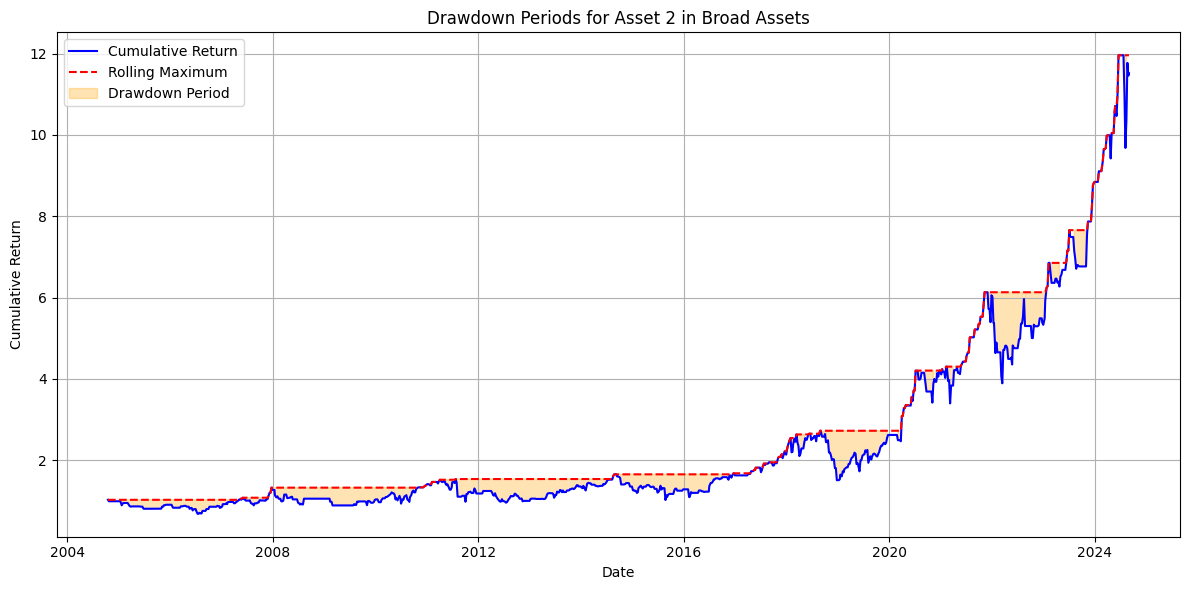

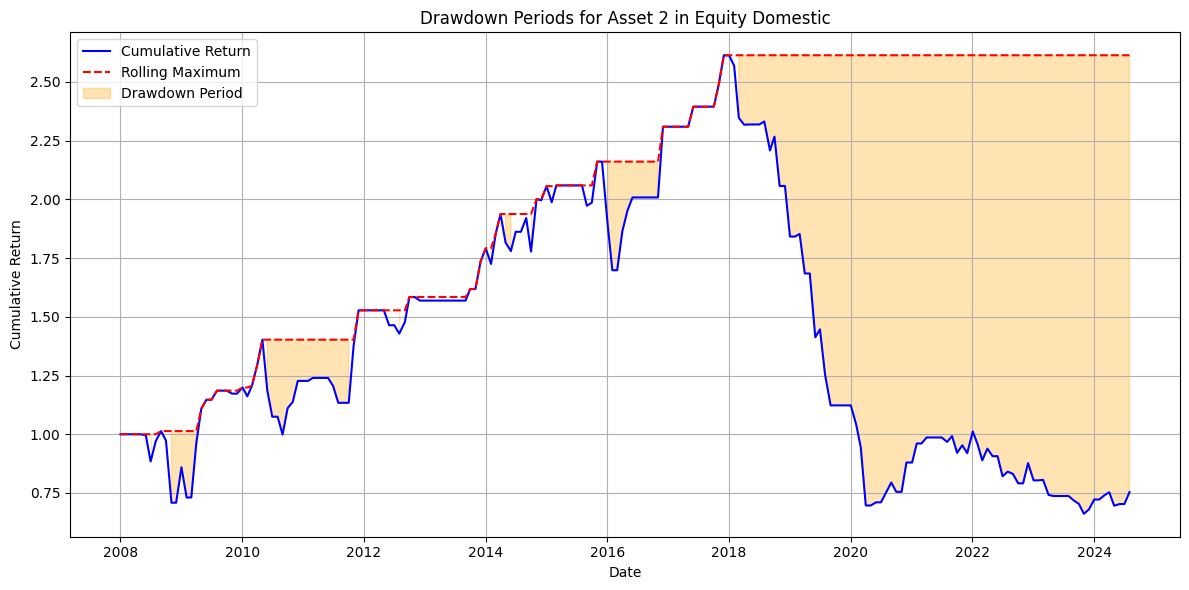

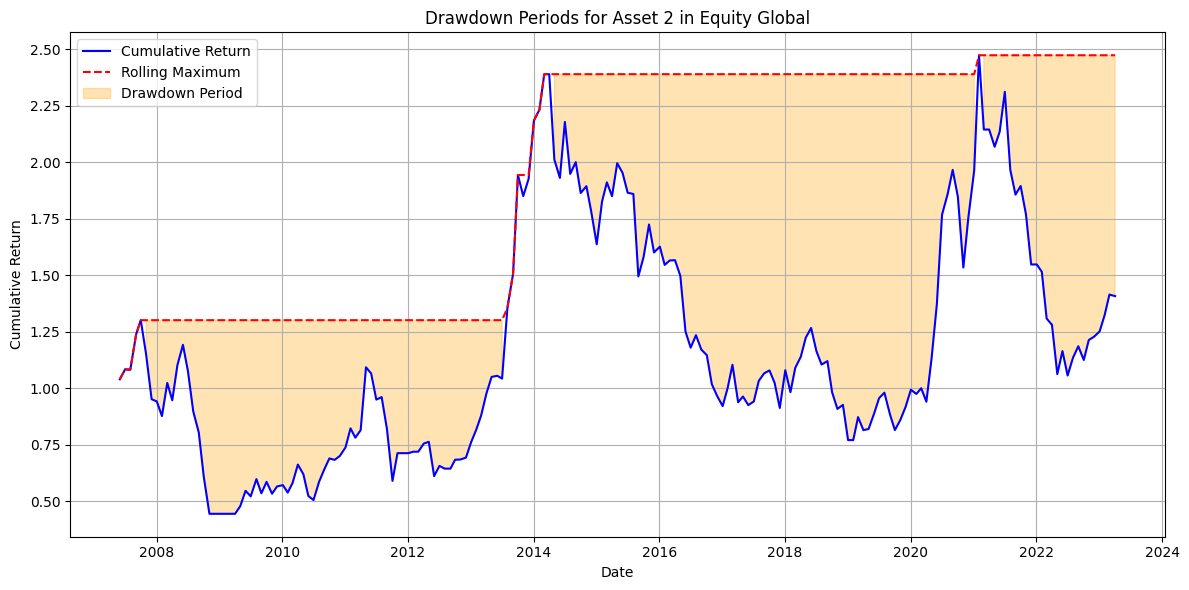

In [9]:
plot_drawdown(broad_assets_cumulative_returns, broad_assets_rolling_max, broad_assets_drawdown_periods, 'Asset 2', 'Broad Assets')
plot_drawdown(equity_domestic_cumulative_returns, equity_domestic_rolling_max, equity_domestic_drawdown_periods, 'Asset 2', 'Equity Domestic')
plot_drawdown(equity_global_cumulative_returns, equity_global_rolling_max, equity_global_drawdown_periods, 'Asset 2', 'Equity Global')

### Risk Signals for Defensive Overlay

In [10]:
broad_assets_rolling_volatility = broad_assets_pred_shifted.rolling(window=21, min_periods=8).std()
equity_domestic_rolling_volatility = equity_domestic_pred_shifted.rolling(window=21, min_periods=8).std()
equity_global_rolling_volatility = equity_global_pred_shifted.rolling(window=21, min_periods=8).std()
display(broad_assets_rolling_volatility, equity_domestic_rolling_volatility, equity_global_rolling_volatility)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2004-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0110,0.0465,0.0162,0.0141,0.0529,0.0323,0.0308,0.0380,0.0161,0.0313,0.0000
2024-08-12,0.0110,0.0490,0.0162,0.0141,0.0530,0.0308,0.0323,0.0427,0.0162,0.0306,0.0000
2024-08-19,0.0238,0.0564,0.0162,0.0141,0.0566,0.0311,0.0380,0.0456,0.0167,0.0307,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.0606,0.0438,0.0421,0.0365,0.0383,0.0775,0.0496,0.0535,0.0704,0.0608,...,0.0350,0.0182,0.0641,0.0589,0.0731,0.0446,0.0440,0.0299,0.0551,0.0049
2024-05-01,0.0595,0.0460,0.0438,0.0363,0.0341,0.0686,0.0487,0.0530,0.0690,0.0555,...,0.0388,0.0243,0.0632,0.0627,0.0692,0.0434,0.0450,0.0295,0.0549,0.0049
2024-06-03,0.0601,0.0462,0.0479,0.0374,0.0297,0.0658,0.0480,0.0522,0.0687,0.0573,...,0.0382,0.0243,0.0589,0.0661,0.0689,0.0402,0.0448,0.0277,0.0525,0.0045


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.0987,0.0795,0.0824,0.0641,0.0852,0.0620,0.0615,0.0981,0.0916,0.0548,...,0.0489,0.0523,0.0415,0.0495,0.0044,0.0259,0.0260,0.0324,0.0511,0.0650
2023-01-03,0.0993,0.0799,0.0828,0.0614,0.0876,0.0613,0.0618,0.1020,0.0930,0.0496,...,0.0484,0.0525,0.0396,0.0498,0.0044,0.0259,0.0259,0.0324,0.0527,0.0682
2023-02-01,0.1075,0.0817,0.0911,0.0673,0.1003,0.0761,0.0624,0.1080,0.0966,0.0533,...,0.0509,0.0587,0.0404,0.0527,0.0044,0.0273,0.0271,0.0344,0.0546,0.0747


In [11]:
broad_assets_rolling_var = calculate_rolling_var(broad_assets_pred_shifted, window=20, confidence_level=0.05)
equity_domestic_rolling_var = calculate_rolling_var(equity_domestic_pred_shifted, window=20, confidence_level=0.05)
equity_global_rolling_var = calculate_rolling_var(equity_global_pred_shifted, window=20, confidence_level = 0.05)
display(broad_assets_rolling_volatility, equity_domestic_rolling_var, equity_global_rolling_var)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2004-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0110,0.0465,0.0162,0.0141,0.0529,0.0323,0.0308,0.0380,0.0161,0.0313,0.0000
2024-08-12,0.0110,0.0490,0.0162,0.0141,0.0530,0.0308,0.0323,0.0427,0.0162,0.0306,0.0000
2024-08-19,0.0238,0.0564,0.0162,0.0141,0.0566,0.0311,0.0380,0.0456,0.0167,0.0307,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.0278,-0.0795,-0.0600,-0.0249,-0.0830,-0.1090,-0.0198,-0.0619,-0.0812,-0.0373,...,-0.0455,-0.0199,-0.0883,-0.0942,-0.1144,-0.0567,-0.0728,-0.0475,-0.0808,-0.0088
2024-05-01,-0.0278,-0.0795,-0.0600,-0.0249,-0.0350,-0.0938,-0.0198,-0.0619,-0.0842,-0.0373,...,-0.0735,-0.0521,-0.0883,-0.0942,-0.1144,-0.0439,-0.0728,-0.0340,-0.0704,-0.0077
2024-06-03,-0.0278,-0.0795,-0.0600,-0.0249,-0.0350,-0.0938,-0.0198,-0.0590,-0.0842,-0.0629,...,-0.0735,-0.0521,-0.0883,-0.0942,-0.1144,-0.0439,-0.0647,-0.0340,-0.0704,-0.0046


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-0.0847,-0.1507,-0.1437,-0.0742,-0.1243,-0.0926,-0.0679,-0.1549,-0.1392,-0.0586,...,-0.0720,-0.0728,-0.0521,-0.0864,-0.0064,-0.0519,-0.0454,-0.0477,-0.0720,-0.0915
2023-01-03,-0.0957,-0.1507,-0.1437,-0.0742,-0.1243,-0.0926,-0.0679,-0.1549,-0.1392,-0.0586,...,-0.0720,-0.0728,-0.0521,-0.0864,-0.0064,-0.0519,-0.0454,-0.0477,-0.0720,-0.0985
2023-02-01,-0.0957,-0.1507,-0.1437,-0.0742,-0.1243,-0.0926,-0.0679,-0.1549,-0.1392,-0.0586,...,-0.0720,-0.0728,-0.0521,-0.0864,-0.0064,-0.0519,-0.0454,-0.0477,-0.0720,-0.0985


## Dynamic Defensive Overlay

#### Methodology
- **Risk Signal Construction**:
  - **Rolling Volatility**: Calculated as the standard deviation of predicted returns over a rolling window to capture short-term fluctuations in asset performance.
  - **Rolling VaR**: Estimated as the percentile-based Value-at-Risk (VaR) of predicted returns over a rolling window, providing a measure of potential downside risk.
  - **Drawdown**: Defined as a return decline exceeding -5% (-0.05), serving as a binary indicator of sustained underperformance.

- **Low-Risk Asset Identification**:
  - Assets are classified as **low risk** if they satisfy all the following criteria:
    1. **Rolling Volatility**: Falls within a predefined low percentile (e.g., bottom 30%).
    2. **Rolling VaR**: Exceeds a high percentile threshold (e.g., top 70%).
    3. **Drawdown Period**: The asset is not currently in a drawdown state.
  - Low-risk assets are left unchanged during the overlay process.

- **High-Risk Asset Adjustment**:
  - For assets that fail to meet any of the above low-risk criteria (e.g., high volatility, low VaR, or currently in a drawdown period), their weights are dynamically reduced, and the excess allocation is shifted to cash.
  - This ensures a defensive posture against portfolio drawdowns, while still maintaining exposure to low-risk opportunities.

#### Implementation Highlights
The function `apply_dynamic_defensive_overlay` implements this logic:
- **Input Parameters**:
  - `portfolio_weights`: Original portfolio weights for each asset.
  - `rolling_volatility`: Historical rolling volatility for each asset.
  - `rolling_var`: Historical rolling Value-at-Risk (VaR) for each asset.
  - `drawdown_period`: A Boolean DataFrame identifying if an asset is in a drawdown period.
  - `cash_allocation`: The max percentage of weight reallocated to cash for high-risk assets.
  - Threshold parameters (`volatility_threshold`, `var_threshold`) to define high/low risk percentiles.

- **Process**:
  - For each date, historical data up to the current date is used to calculate the rolling volatility and VaR percentiles dynamically.
  - Assets meeting all low-risk conditions are left unchanged.
  - Weights of high-risk assets are reduced, with the removed allocation shifted into a cash position.
  - Portfolio weights are normalized after adjustments to ensure they sum to 1.

In [12]:
broad_assets_portfolio_weights_updated = apply_dynamic_defensive_overlay(broad_assets_portfolio_weights,
                                                                         broad_assets_rolling_volatility,
                                                                         broad_assets_rolling_var,
                                                                         broad_assets_drawdown_periods,
                                                                         cash_allocation=0.2,
                                                                         volatility_threshold=0.15,
                                                                         var_threshold=0.15)

equity_domestic_portfolio_weights_updated = apply_dynamic_defensive_overlay(equity_domestic_portfolio_weights,
                                                                            equity_domestic_rolling_volatility,
                                                                            equity_domestic_rolling_var,
                                                                            equity_domestic_drawdown_periods,
                                                                            cash_allocation=0.2,
                                                                            volatility_threshold=0.15,
                                                                            var_threshold=0.15)

equity_global_portfolio_weights_updated = apply_dynamic_defensive_overlay(equity_global_portfolio_weights,
                                                                          equity_global_rolling_volatility,
                                                                          equity_global_rolling_var,
                                                                          equity_global_drawdown_periods,
                                                                          cash_allocation=0.2,
                                                                          volatility_threshold=0.15,
                                                                          var_threshold=0.15)
display(broad_assets_portfolio_weights_updated, equity_domestic_portfolio_weights_updated, equity_global_portfolio_weights_updated)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,Cash
Date,,,,,,,,,,,,
2005-10-17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2314,0.3467,0.0791,0.0000,0.2140,0.1287
2005-10-24,0.0120,0.0000,0.0997,0.1083,0.0000,0.0000,0.0000,0.4630,0.0000,0.0000,0.1667,0.1504
2005-10-31,0.0000,0.2866,0.0000,0.3635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1801,0.1698
2005-11-07,0.0000,0.0000,0.0000,0.1435,0.0000,0.0000,0.1833,0.5033,0.0000,0.0000,0.0000,0.1698
2005-11-14,0.0000,0.2477,0.0000,0.0000,0.0588,0.0000,0.0000,0.0000,0.5422,0.0000,0.0000,0.1514
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.0000,0.2126,0.0000,0.0000,0.2253,0.2318,0.1303,0.0000,0.0000,0.0000,0.0000,0.2000
2024-08-12,0.1279,0.1102,0.0000,0.0000,0.1448,0.2084,0.0423,0.0000,0.0000,0.1889,0.0000,0.1775
2024-08-19,0.0000,0.2496,0.0000,0.0000,0.1634,0.1441,0.0760,0.0023,0.0000,0.2252,0.0000,0.1394


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46,Cash
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.1294,0.1542,0.1644,0.0000,0.1236,0.1286,0.0000,0.0483
2005-07-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2594,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2423,0.0438
2005-08-01,0.0000,0.0000,0.0000,0.1409,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.1354,0.1487,0.0000,0.0000,0.0000,0.0000,0.0176
2005-09-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.2718,0.0000,0.2146,0.0000,0.0000,0.0000,0.0000,0.0236
2005-10-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.2175,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.0000,0.0291,0.0394,0.0000,0.0000,0.0169,0.0329,0.0000,0.0369,0.0000,...,0.0172,0.0355,0.0380,0.0270,0.0000,0.0373,0.0209,0.0181,0.0231,0.1541
2024-05-01,0.0251,0.0167,0.0276,0.0269,0.0176,0.0080,0.0300,0.0244,0.0180,0.0230,...,0.0043,0.0226,0.0212,0.0182,0.0238,0.0000,0.0110,0.0083,0.0000,0.1552
2024-06-03,0.0000,0.0000,0.0000,0.0473,0.0341,0.0286,0.0530,0.0436,0.0000,0.0390,...,0.0200,0.0416,0.0510,0.0000,0.0000,0.0551,0.0279,0.0258,0.0299,0.1588


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52,Cash
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-01,0.0000,0.0699,0.0000,0.0000,0.0000,0.0000,0.0000,0.6093,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0951
2008-06-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5825,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1005,0.1019
2008-07-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6510,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1149
2008-08-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.1182
2008-09-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.6053,0.0000,0.2943,0.0000,0.0000,0.0000,0.0000,0.1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1600
2023-01-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1503
2023-02-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1362


In [13]:
broad_assets_strategy_rets = calculate_portfolio_returns(broad_assets_portfolio_weights_updated, data)
broad_assets_strategy_stats = summary_statistics_annualized(broad_assets_strategy_rets)
broad_assets_strategy_rets_df = pd.DataFrame(broad_assets_strategy_rets, columns = ['Return'])
broad_assets_strategy_rets_df['CumRet'] = cal_cum_return(broad_assets_strategy_rets_df['Return'])

equity_domestic_strategy_rets = calculate_portfolio_returns(equity_domestic_portfolio_weights_updated, domestic_data)
equity_domestic_strategy_stats = summary_statistics_annualized(equity_domestic_strategy_rets, annual_factor = 12)
equity_domestic_strategy_rets_df = pd.DataFrame(equity_domestic_strategy_rets, columns = ['Return'])
equity_domestic_strategy_rets_df['CumRet'] = cal_cum_return(equity_domestic_strategy_rets_df['Return'])

equity_global_strategy_rets = calculate_portfolio_returns(equity_global_portfolio_weights_updated, global_data)
equity_global_strategy_stats = summary_statistics_annualized(equity_global_strategy_rets, annual_factor = 12)
equity_global_strategy_rets_df = pd.DataFrame(equity_global_strategy_rets, columns = ['Return'])
equity_global_strategy_rets_df['CumRet'] = cal_cum_return(equity_global_strategy_rets_df['Return'])

In [14]:
print('The summary stats for broad assets after defensive overlay (classification + weighting included):')
display(broad_assets_strategy_stats)
print('The summary stats for equity domestic after defensive overlay (classification + weighting included):')
display(equity_domestic_strategy_stats)
print('The summary stats for equity global after defensive overlay (classification + weighting included):')
display(equity_global_strategy_stats)

The summary stats for broad assets after defensive overlay (classification + weighting included):


,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
0,0.1572,0.2386,0.6589,-0.1597,0.1908,-0.0008,4.3238,-0.0472,-0.0763,-0.4028


The summary stats for equity domestic after defensive overlay (classification + weighting included):


,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
0,0.1043,0.1447,0.7207,-0.1501,0.1375,-0.6904,1.5234,-0.0646,-0.0969,-0.3569


The summary stats for equity global after defensive overlay (classification + weighting included):


,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
0,0.1281,0.2204,0.5811,-0.1389,0.2265,0.6002,1.1367,-0.0879,-0.1084,-0.3883


Comparing these results with the summary statistics prior to implementing the defensive overlay, we observe a slight reduction in the mean return. However, there is a substantial decrease in maximum drawdown, volatility, Value at Risk (VaR), and Conditional Value at Risk (CVaR). This demonstrates the effectiveness of the defensive overlay in mitigating risk and enhancing the portfolio’s resilience against adverse market conditions.

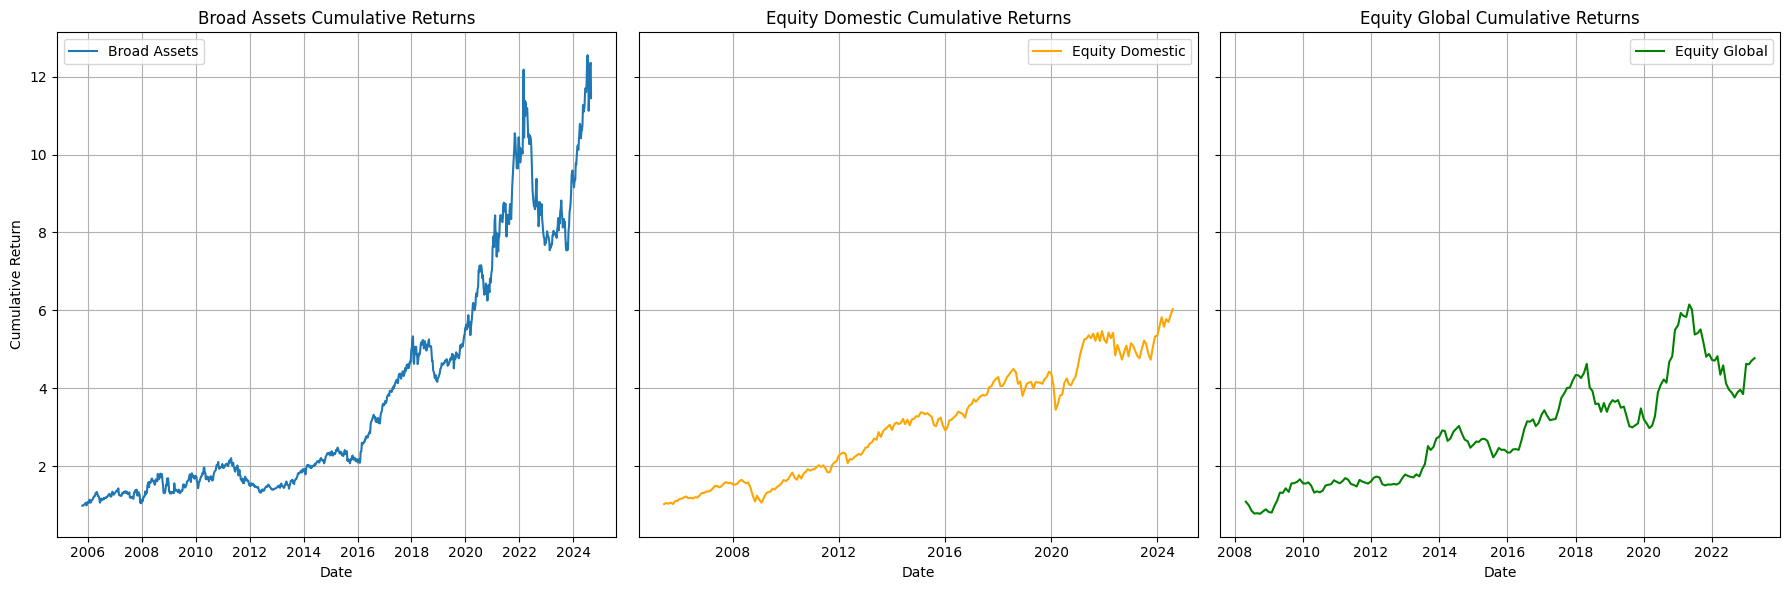

In [15]:
plot_cum_returns_three_universes(broad_assets_strategy_rets_df,
                                 equity_domestic_strategy_rets_df,
                                 equity_global_strategy_rets_df,
                                 cal_cum_return)

## Useful Visualizations

Visualize the results of the defensive overlay.

- The first set of charts demonstrate the portfolio weights after implementing the defensive overlay. It effectively highlights the cash allocation introduced across the portfolios. The addition of the cash component ensures enhanced stability and risk mitigation, particularly during volatile market periods. The visualization captures the dynamic nature of weights over time, with cash allocation (orange) clearly evident in later periods, especially during market downturns.

- The second set of charts present a direct comparison of portfolio variance before and after the defensive overlay. The blue line represents the variance prior to applying the defensive strategy, while the orange line reflects the variance post-application. The green area between the two lines indicates the variance reduction achieved. This visualization effectively underscores the impact of the defensive overlay in reducing portfolio volatility, showcasing its effectiveness in smoothing the risk profile of the portfolio over time, particularly during periods of heightened market turbulence.

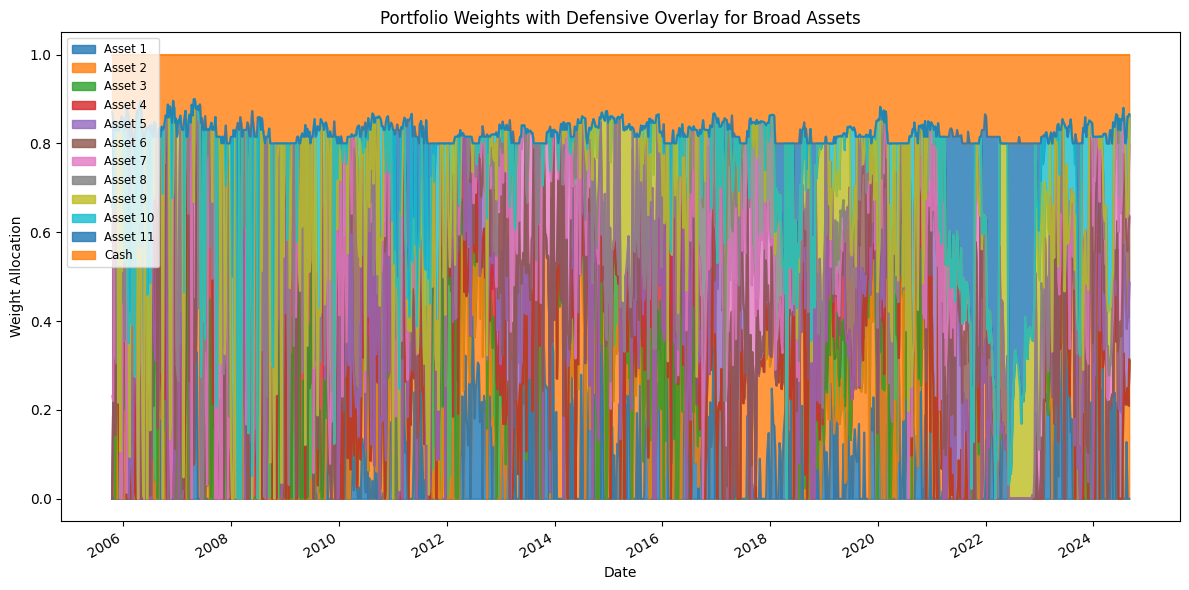

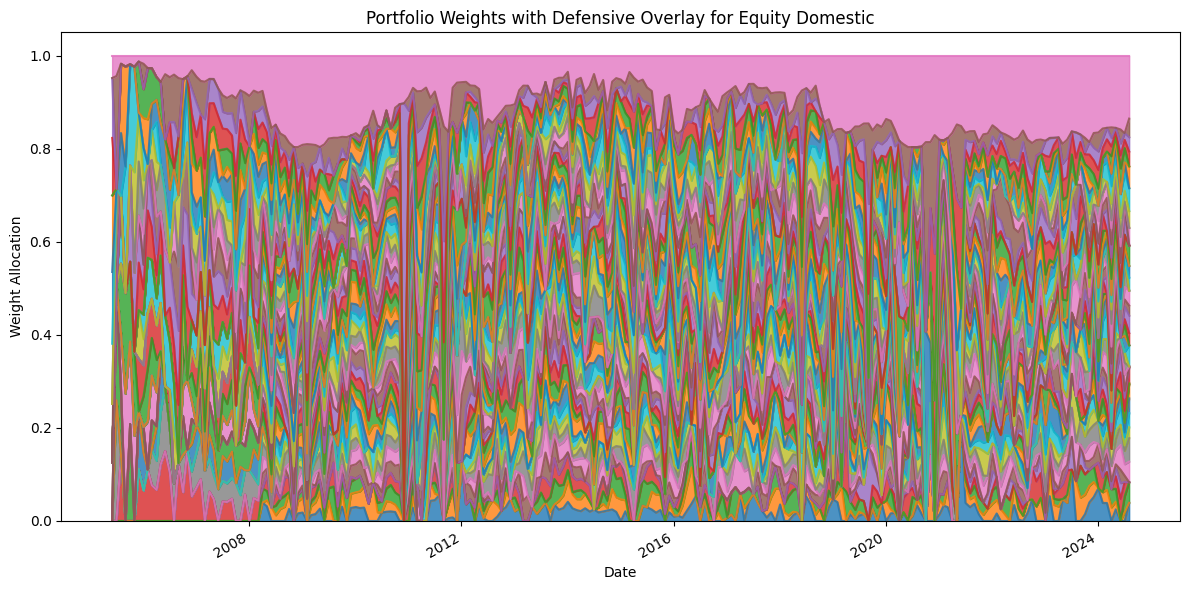

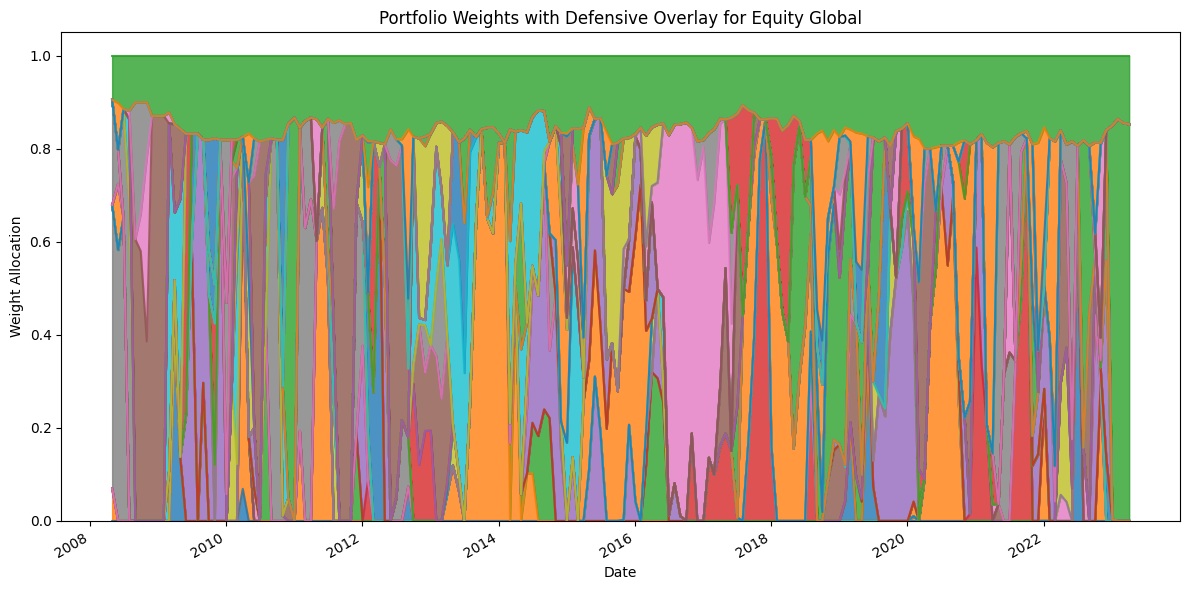

In [16]:
plot_portfolio_weights_only(broad_assets_portfolio_weights_updated, "Portfolio Weights with Defensive Overlay for Broad Assets", show_legend=True)
plot_portfolio_weights_only(equity_domestic_portfolio_weights_updated, "Portfolio Weights with Defensive Overlay for Equity Domestic", show_legend=False)
plot_portfolio_weights_only(equity_global_portfolio_weights_updated, "Portfolio Weights with Defensive Overlay for Equity Global", show_legend=False)


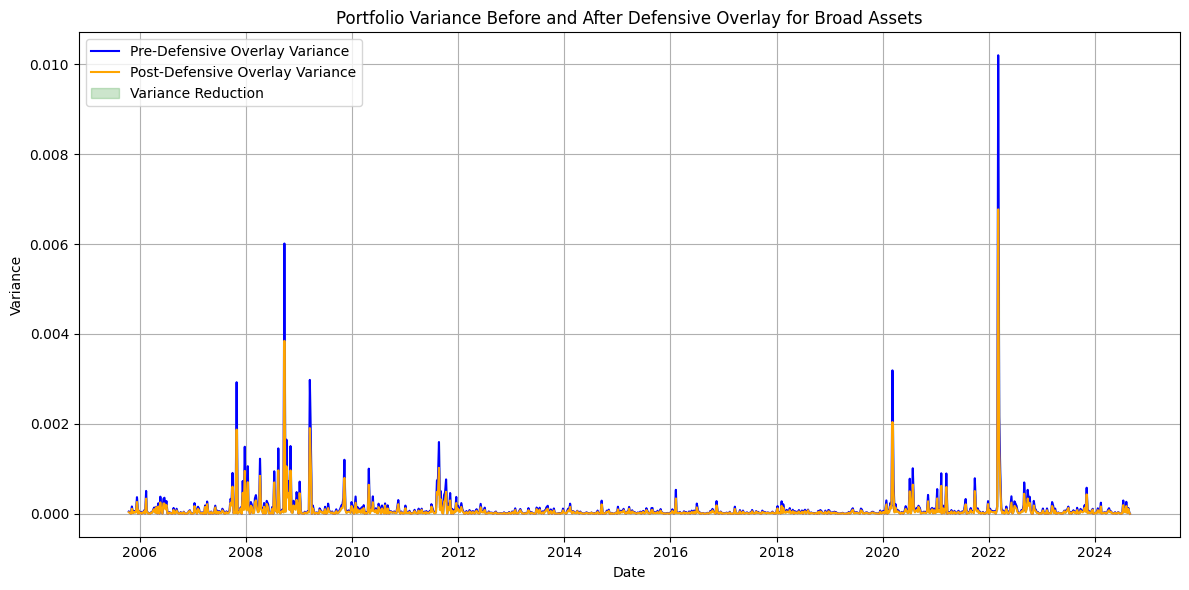

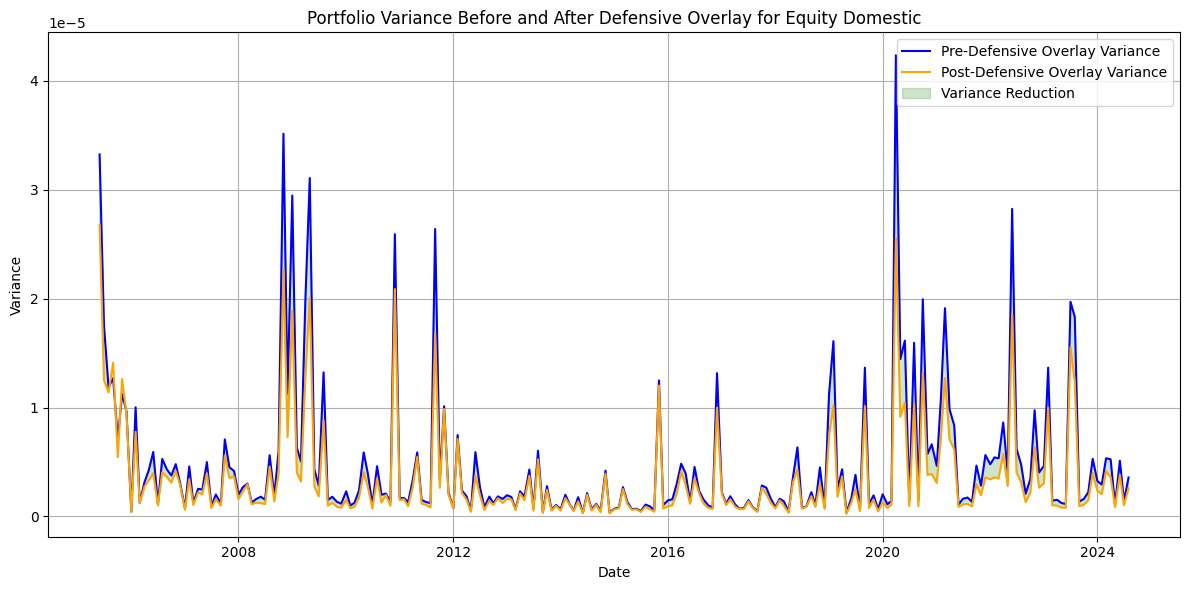

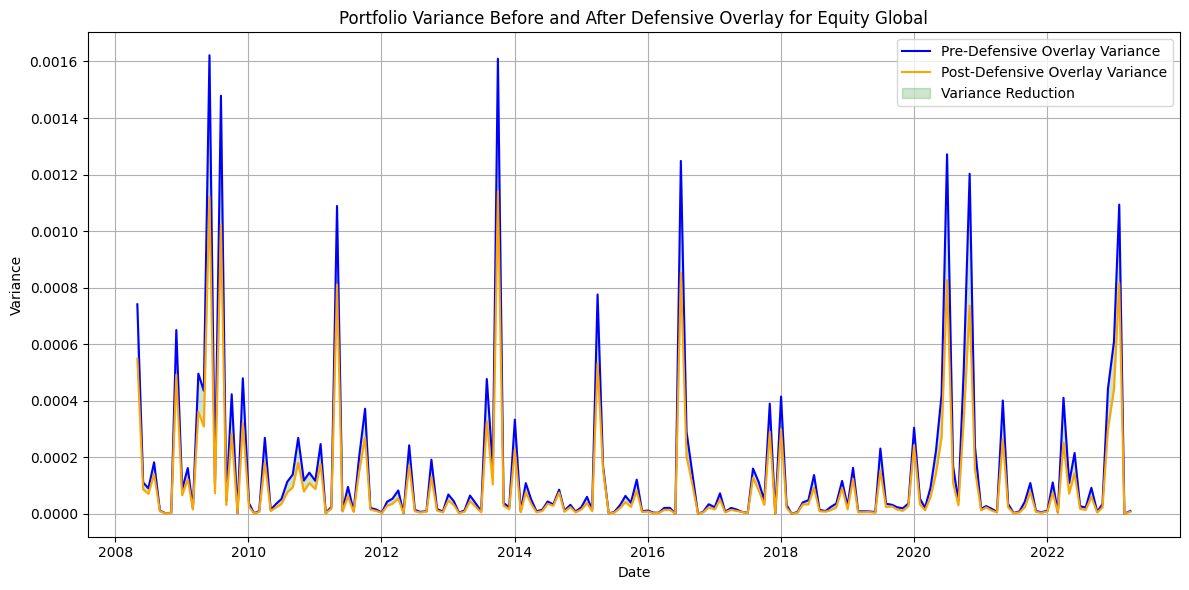

In [17]:
plot_variance_reduction(data, broad_assets_portfolio_weights, broad_assets_portfolio_weights_updated, 'Broad Assets')
plot_variance_reduction(domestic_data, equity_domestic_portfolio_weights, equity_domestic_portfolio_weights_updated, 'Equity Domestic')
plot_variance_reduction(global_data, equity_global_portfolio_weights, equity_global_portfolio_weights_updated, 'Equity Global')

## Future Improvements

While the current defensive overlay effectively mitigates portfolio drawdowns, it still has some limitations that could be addressed to further enhance its flexibility and performance:

- **Static Cash Allocation**:
  - In many scenarios, the cash allocation frequently reaches the predefined maximum value, which may limit the portfolio's adaptability to varying market conditions. This static approach might not always align with the dynamic nature of financial markets.

- **Categorizing Assets into Risk Tiers**:
  - A potential enhancement is to categorize assets into **low-risk assets**, **high-risk assets**, and **cash** based on their risk profiles. Instead of using a fixed cash allocation, a portfolio-wide volatility threshold can be introduced to determine the optimal allocation dynamically.

- **Mean-Variance Optimization**:
  - By setting a target portfolio volatility threshold, weights for **low-risk assets**, **high-risk assets**, and **cash** can be determined using a mean-variance optimization framework.
  - This approach would allow for solving the optimal cash weight that balances the trade-off between risk reduction and return maximization.

- **Alternative Cash Weight Calculation**:
  - Instead of directly shifting weights to cash based on a fixed allocation, other approaches can be explored, such as:
    - Using a **risk-parity-based method** to allocate cash weights relative to asset-level risks.
    - Adjusting cash allocation proportionally to the expected drawdown of high-risk assets.

- **Incorporating Predictive Signals**:
  - The model could leverage predictive signals, such as forward-looking indicators (e.g., macroeconomic factors, sentiment analysis), to better anticipate high-risk periods and adjust allocations proactively.

- **Transaction Costs**:
  - The current framework does not explicitly account for transaction costs incurred during frequent rebalancing. Adding a constraint to limit turnover or incorporating transaction costs into the optimization process would make the overlay more realistic and implementable in practice.

By addressing these areas, the defensive overlay can be transformed into a more adaptive and robust framework that balances risk management with return optimization, ultimately improving its applicability in real-world portfolio management scenarios.